In [1]:
#############################################################

# Project: External Finance Data 

# Step: Prepare ABS Mortgage Lending Data

# Purpose: The ABS data is highly segregated and requires significant
# wrangling in order to clean and use for analytical purposes.

# Author: Michael Letheby

#############################################################

In [2]:
#############################################################

# Section: Libraries

#############################################################

import pandas as pd # Data Analysis Library
import matplotlib.pyplot as plt # Data Visualisation Library
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

import math
import seaborn as sns # Data Visualisation Library
import requests # For downloading 
from datetime import date
from datetime import datetime
import re # Regex
import numbers 

from bs4 import BeautifulSoup                

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

import pickle # for saving/loading files

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#############################################################

# Section: Functions

#############################################################

# pickle_save: save the files after importing and reading them
def pickle_save(name, to_save):
    with open('../Data/' + name + '.pickle', 'wb') as handle:
        pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
# picle_load: load previously saved files
def pickle_load(name):
    with open('../Data/' + name + '.pickle', 'rb') as handle:
        load_data = pickle.load(handle)
    return load_data

# match: search each string element within a list ('list_search') in a string ('in_string') and  
# return the match. Used to define the type of variable within the ABS Lending Indicator datasets.
def match(list_search, in_string):
    # need to add restrictions on input types to list + string
    result = [f for f in list_search if re.search(f, desclist)] 
    return(result)

# human_format: format numbers to be more readable 
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

# agg_clean: aggregates a dataframe and creates the avg_loan variable
def agg_clean(df_input, groupby_array):
    df_output = df_input.groupby(groupby_array).sum().reset_index()
    df_output['avg_loan'] = df_output['value']/df_output['number']
    return df_output

# join_fun: join together two dataframes
def join_fun(df_base, df_join, joinby_array):
    df_output = df_base.merge(df_join, how='left', on=joinby_array, suffixes = (None, '_join'))
    return df_output

# join_fun: create indexed variables
def index_clean(df_input, var_input, suffix):
    for var in var_input:
        new_var = suffix + '_' + var
        join_var = var + '_join'
        df_input[new_var] = df_input[var]/df_input[join_var]
          
    df_output = df_input.drop([col for col in df_input.columns if col.endswith('_join')],axis=1)
    return df_output

# round_up: round up a number to the nearest denominator (i.e. nearest 50,000)
def round_up(number, round_to_nearest):
    return(math.ceil(number/round_to_nearest)*round_to_nearest)

# round_up: round down a number to the nearest denominator (i.e. nearest 50,000)
def round_down(number, round_to_nearest):
    return(math.floor(number/round_to_nearest)*round_to_nearest)

In [4]:
#############################################################

# Section: Data Import and Clean

#############################################################

output_df = pickle_load('imported_data_final')['ABS']['Final_Data']

# A number of the 'Series' are present in multiple files so must be deduped
output_df = output_df.drop_duplicates(subset=['Date', 'variable', 'value', 'location', 'lender_type', 'buyer_type' \
                                               ,'buyer_subtype','measure_type','measure_subtype'])

output_df = output_df.loc[-(output_df['location']=='AUS')]
output_df = output_df.loc[output_df['lender_type']=='all']
output_df = output_df.loc[output_df['buyer_type'].isin(['investor', 'owner occupier'])]

output_df.drop(['variable', 'file_ref', 'lender_type'], axis=1, inplace=True)

# Without filling NAs the subsequent calculations break
output_df['value'] = output_df['value'].fillna(0)

# Need to clean the data and separate out non-FHB from FHB
all_total_exc_refi = output_df.loc[(output_df.buyer_subtype.isin(['all'])) & 
              (output_df.measure_type.isin(['total_exc_refi']))]

all_ext_refi = output_df.loc[(output_df.buyer_subtype.isin(['all'])) & 
              (output_df.measure_type.isin(['ext_refi']))]

fhb_total_exc_refi = output_df.loc[(output_df.buyer_subtype.isin(['first home buyer'])) & 
              (output_df.measure_type.isin(['total_exc_refi']))]

all_total_exc_refi = all_total_exc_refi.merge(fhb_total_exc_refi[['Date', 'location', 'buyer_type', 'measure_subtype', 'value']]
                         , how='left', on=['Date', 'location', 'buyer_type', 'measure_subtype']
                         , suffixes = (None, '_FHB'))

all_total_exc_refi['value'] = all_total_exc_refi['value'] - all_total_exc_refi['value_FHB']

all_total_exc_refi.drop(['value_FHB'], axis=1, inplace=True)

output_df = pd.concat([all_total_exc_refi, fhb_total_exc_refi, all_ext_refi])

output_df.loc[output_df['buyer_subtype']=='first home buyer',['lender_type']] = 'FHB'
output_df.loc[output_df['buyer_subtype']!='first home buyer',['lender_type']] = 'Non-FHB'

output_df = output_df.pivot_table(index=['Date', 'location', 'lender_type', 'buyer_type','buyer_subtype' \
                                         ,'measure_type'],
                                  columns='measure_subtype',
                                 values='value', aggfunc='sum').reset_index()

output_df.drop(['buyer_subtype'], axis=1, inplace=True)

In [5]:
#############################################################

# Section: Data Preparation for Visualisation

#############################################################

groupby_main = ['Date', 'measure_type']
joinby_main = ['measure_type']
var_list = ['number', 'value', 'avg_loan']

# Date to use as the start of the index
first_date = '2020-01-01'
latest_date = output_df['Date'].max()
latest_date_L12M = output_df['Date'].max() + pd.DateOffset(years=-1)

# Refinance vs Purchase
df_ext_refi = agg_clean(output_df[output_df['measure_type']=='ext_refi'], groupby_main)
df_ext_refi = join_fun(df_ext_refi, df_ext_refi[df_ext_refi['Date']==first_date], joinby_main)
df_ext_refi = index_clean(df_ext_refi, var_list, 'index')

df_tot_exc_refi = agg_clean(output_df[output_df['measure_type']=='total_exc_refi'], groupby_main)
df_tot_exc_refi = join_fun(df_tot_exc_refi, df_tot_exc_refi[df_tot_exc_refi['Date']==first_date], joinby_main)
df_tot_exc_refi = index_clean(df_tot_exc_refi, var_list, 'index')

df_main = pd.concat([df_ext_refi, df_tot_exc_refi])

# Show % of Total Mortgages
groupby_main = ['Date']
var_list = ['number', 'value']

df_tot = agg_clean(output_df, groupby_main)
df_main = join_fun(df_main, df_tot, groupby_main)
df_main = index_clean(df_main, var_list, 'total')

# FHB vs Investor vs Owner Occupier
groupby_fhb = ['Date', 'measure_type', 'lender_type']
joinby_fhb = ['measure_type', 'lender_type']
groupby_detailed = ['Date', 'measure_type', 'buyer_type']
joinby_detailed = ['measure_type', 'buyer_type']
var_list = ['number', 'value', 'avg_loan']

df_fhb = agg_clean(output_df[(output_df['measure_type']=='total_exc_refi') &
                                     (output_df['lender_type']=='FHB')], groupby_fhb)
df_fhb = join_fun(df_fhb, df_fhb[df_fhb['Date']==first_date], joinby_fhb)
df_fhb = index_clean(df_fhb, var_list, 'index')
df_fhb.rename(columns={'lender_type' : 'buyer_type'}, inplace=True)
                                                      
df_detailed = agg_clean(output_df[(output_df['measure_type']=='total_exc_refi') &
                                     (output_df['lender_type']=='Non-FHB')], groupby_detailed)
df_detailed = join_fun(df_detailed, df_detailed[df_detailed['Date']==first_date], joinby_detailed)
df_detailed = index_clean(df_detailed, var_list, 'index')

df_detailed = pd.concat([df_detailed, df_fhb])

# Show % of Total non-Refi Mortgages
var_list = ['number', 'value']

df_detailed = join_fun(df_detailed, df_tot_exc_refi, groupby_main)
df_detailed = index_clean(df_detailed, var_list, 'total')

# Plot FHB by State as of latest month and change since 12 months ago
groupby_fhb_state = ['Date', 'measure_type', 'lender_type', 'location']
joinby_fhb_state = ['measure_type', 'lender_type', 'location']
var_list = ['number', 'value', 'avg_loan']
var_list_yoy = ['avg_loan_3m']

df_fhb = agg_clean(output_df[(output_df['measure_type']=='total_exc_refi') & (output_df['lender_type']=='FHB')]
                   , groupby_fhb_state)

df_fhb = join_fun(df_fhb, df_fhb[df_fhb['Date']==first_date], joinby_fhb_state)
df_fhb = index_clean(df_fhb, var_list, 'index')

df_fhb.sort_values(by=['location', 'Date'], inplace=True)

df_fhb['value_3m'] = df_fhb.groupby('location')['value'].rolling(3).sum().reset_index(0,drop=True)
df_fhb['number_3m'] = df_fhb.groupby('location')['number'].rolling(3).sum().reset_index(0,drop=True)
df_fhb['avg_loan_3m'] = df_fhb['value_3m']/df_fhb['number_3m']

# Australia FHB Avg Loan Size
df_fhb_agg = agg_clean(df_fhb, groupby_main)
df_fhb_agg['location'] = 'AUS'
df_fhb_agg['value_3m'] = df_fhb_agg['value'].rolling(3).sum().reset_index(0,drop=True)
df_fhb_agg['number_3m'] = df_fhb_agg['number'].rolling(3).sum().reset_index(0,drop=True)
df_fhb_agg['aus_avg_loan_3m'] = df_fhb_agg['value_3m']/df_fhb_agg['number_3m']

df_fhb_agg = df_fhb_agg[['Date', 'location', 'aus_avg_loan_3m']]
df_fhb_agg = join_fun(df_fhb_agg, df_fhb_agg[df_fhb_agg['Date']==latest_date_L12M]
                             , 'location')
df_fhb_agg = index_clean(df_fhb_agg, ['aus_avg_loan_3m'], 'yoy')
df_fhb_agg = df_fhb_agg.loc[(df_fhb_agg['Date']==latest_date)] 

df_fhb_agg['yoy_aus_avg_loan_3m'] = df_fhb_agg['yoy_aus_avg_loan_3m'] - 1

# Calculate YoY change by location
df_fhb = join_fun(df_fhb, df_fhb[df_fhb['Date']==latest_date_L12M], joinby_fhb_state)
df_fhb = index_clean(df_fhb, var_list_yoy, 'yoy')

# Filter for latest date
df_fhb = df_fhb[df_fhb['Date']==latest_date]
df_fhb['yoy_avg_loan_3m'] = df_fhb['yoy_avg_loan_3m'] - 1
df_fhb.rename(columns={'lender_type' : 'buyer_type'}, inplace=True)

# Join AUS Average to States
df_fhb['aus_avg_loan_3m'] = df_fhb_agg['aus_avg_loan_3m'].values[0]
df_fhb['yoy_aus_avg_loan_3m'] = df_fhb_agg['yoy_aus_avg_loan_3m'].values[0]

state_order = df_fhb.sort_values('avg_loan_3m', ascending=False).reset_index(drop=True)
state_order = state_order['location'].values

# show average loan size for each state split between FHB, Inv, OO as of latest month and change from 12 months ago
groupby_state_detailed = ['Date', 'measure_type', 'lender_type', 'buyer_type', 'location']
joinby_nonfhb_detailed = ['measure_type', 'lender_type', 'buyer_type', 'location']

df_state_detailed = agg_clean(output_df[(output_df['measure_type']=='total_exc_refi') & (output_df['lender_type']!='FHB')]
                   , groupby_state_detailed)
df_state_detailed.sort_values(by=['buyer_type', 'location', 'Date'], inplace=True)

df_state_detailed['value_3m'] = df_state_detailed.groupby('location')['value'].rolling(3).sum().reset_index(0,drop=True)
df_state_detailed['number_3m'] = df_state_detailed.groupby('location')['number'].rolling(3).sum().reset_index(0,drop=True)
df_state_detailed['avg_loan_3m'] = df_state_detailed['value_3m']/df_state_detailed['number_3m']

df_state_detailed = join_fun(df_state_detailed, df_state_detailed[df_state_detailed['Date']==latest_date_L12M]
                             , joinby_nonfhb_detailed)
df_state_detailed = index_clean(df_state_detailed, var_list_yoy, 'yoy')
df_state_detailed = df_state_detailed.loc[(df_state_detailed['Date']==latest_date)] 

df_state_detailed['yoy_avg_loan_3m'] = df_state_detailed['yoy_avg_loan_3m'] - 1
df_state_detailed = pd.concat([df_state_detailed, df_fhb])

# Combine Australia Avg Loan Size 

df_state_detailed['aus_avg_loan_3m'] = df_fhb_agg['aus_avg_loan_3m'].values[0]
df_state_detailed['yoy_aus_avg_loan_3m'] = df_fhb_agg['yoy_aus_avg_loan_3m'].values[0]

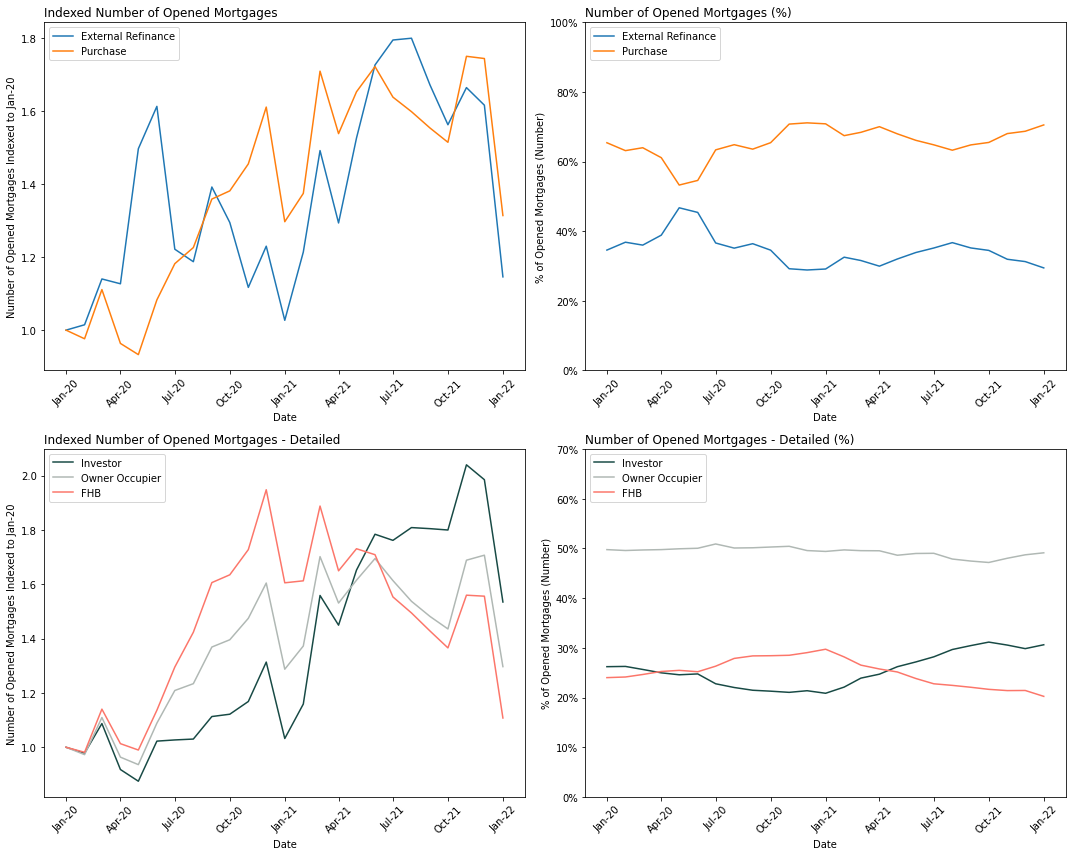

In [6]:
#############################################################

# Section: Graphs

#############################################################

#############################################################
# Section: Graphs - High Level Views
#############################################################

df_main = df_main[df_main['Date']>=first_date]
df_detailed = df_detailed[df_detailed['Date']>=first_date]

f, axes = plt.subplots(2,2, figsize=(15,12))

# Number of Opened Refi vs Purchase Mortgages - Indexed by number
graph_basic = sns.lineplot(x='Date', y='index_number', data=df_main, hue = 'measure_type', ax=axes[0,0])
graph_basic.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# % of Total Number of Opened Mortgages - Refi vs Purchase
graph_basic_total = sns.lineplot(x='Date', y='total_value', data=df_main, hue = 'measure_type', ax=axes[0,1])
graph_basic_total.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))
graph_basic_total.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# Number of Purchased Mortgages by Buyer Type - Indexed by number
palette_custom = ['#184A45FF', '#B0B8B4FF', '#FC766AFF']
graph_detailed = sns.lineplot(x='Date', y='index_number', data=df_detailed, hue = 'buyer_type'
                              , palette=palette_custom, ax=axes[1,0])
graph_detailed.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

# % of Total Number of Purchased Mortgages by Buyer Type
graph_detailed_total = sns.lineplot(x='Date', y='total_number', data=df_detailed, hue = 'buyer_type'
                                   , palette=palette_custom)
graph_detailed_total.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))
graph_detailed_total.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))

graphs = []

# Use value NONE where invalid
graphs.append({
    'graph': graph_basic,
    'title': 'Indexed Number of Opened Mortgages',
    'label-x': 'Date',
    'label-y': 'Number of Opened Mortgages Indexed to Jan-20',
    'legend': 'upper left',
    'labels': ('External Refinance', 'Purchase'),
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 'NONE',
    'limit-y-upper': 'NONE',  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'N',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE',
})

graphs.append({
    'graph': graph_basic_total,
    'title': 'Number of Opened Mortgages (%)',
    'label-x': 'Date',
    'label-y': '% of Opened Mortgages (Number)',
    'legend': 'upper left',
    'labels': ('External Refinance', 'Purchase'),
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': 1,  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'N',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE',
})

graphs.append({
    'graph': graph_detailed,
    'title': 'Indexed Number of Opened Mortgages - Detailed',
    'label-x': 'Date',
    'label-y': 'Number of Opened Mortgages Indexed to Jan-20',
    'legend': 'upper left',
    'labels': ('Investor', 'Owner Occupier', 'FHB'),
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 'NONE',  
    'limit-y-upper': 'NONE', 
    'rotate-x-ticks': 45,
    'date-axis-spread': 'N',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE',
})

graphs.append({
    'graph': graph_detailed_total,
    'title': 'Number of Opened Mortgages - Detailed (%)',
    'label-x': 'Date',
    'label-y': '% of Opened Mortgages (Number)',
    'legend': 'upper left',
    'labels': ('Investor', 'Owner Occupier', 'FHB'),
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': 0.7,  
    'rotate-x-ticks': 45,
    'date-axis-spread': 'N',
    'secondary-graph': 'NONE',
    'secondary-label-y': 'NONE',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 'NONE',
    'secondary-limit-y-upper': 'NONE',
})

for graph in graphs: #Loop to set all graph parameters
    graph['graph'].set_title(graph['title'], loc='left') 
    graph['graph'].set(xlabel=graph['label-x'], ylabel=graph['label-y'])
            
    if graph['labels'] != 'NONE': # Legend Labels      
        graph['graph'].legend(labels=graph['labels'], loc=graph['legend'])
    if graph['limit-x-lower'] != 'NONE': # X Limits
        graph['graph'].set_xlim(graph['limit-x-lower'], graph['limit-x-upper']) 
    if graph['limit-y-lower'] != 'NONE': # Y Limits
        graph['graph'].set_ylim(graph['limit-y-lower'], graph['limit-y-upper'])       
    if graph['rotate-x-ticks'] != 'NONE': # X Tick Rotation
        graph['graph'].xaxis.set_tick_params(labelrotation=graph['rotate-x-ticks'])
    if graph['date-axis-spread'] == 'Y':
        for ind, label in enumerate(graph['graph'].get_xticklabels()):
            if ind % 3 == 0:  # every 3rd label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    if graph['secondary-graph'] != 'NONE':
        graph['secondary-graph'].set(ylabel=graph['secondary-label-y'])
        
        if graph['secondary-legend'] != 'NONE':
            graph['secondary-graph'].legend(loc=graph['secondary-legend']) 
        if graph['secondary-limit-y-lower'] != 'NONE':
            graph['secondary-graph'].set_ylim(graph['secondary-limit-y-lower'], graph['secondary-limit-y-upper'])   

plt.tight_layout()
plt.show()

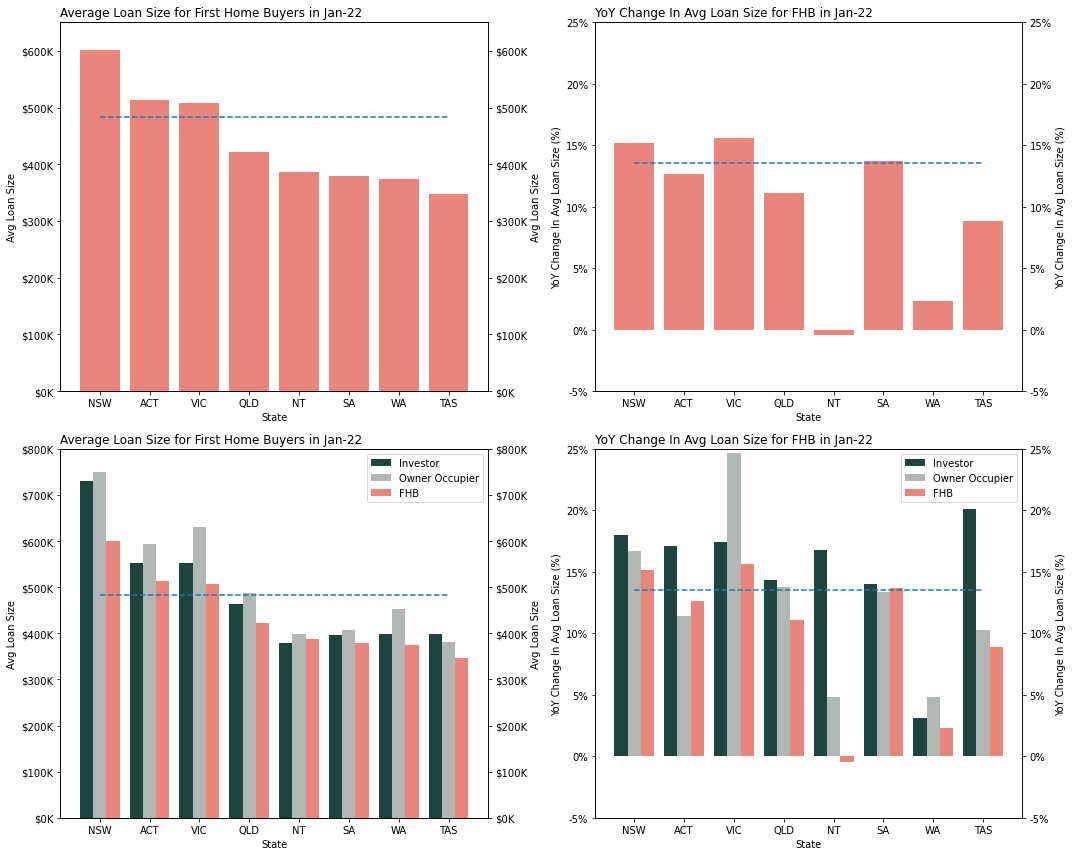

In [18]:
max_avg_loan_balance = round_up(df_fhb['avg_loan_3m'].max(),50000)
max_yoy_avg_loan = round_up(df_fhb['yoy_avg_loan_3m'].max(),0.05)
min_yoy_avg_loan = round_down(df_fhb['yoy_avg_loan_3m'].min(),0.05)

max_detailed_avg_loan_balance = round_up(df_state_detailed['avg_loan_3m'].max(),50000)
max_yoy_detailed_avg_loan = round_up(df_state_detailed['yoy_avg_loan_3m'].max(),0.05)
min_yoy_detailed_avg_loan = round_down(df_state_detailed['yoy_avg_loan_3m'].min(),0.05)

latest_date_mmyyy = latest_date.strftime("%b-%y")

#############################################################
# Section: Graphs - FHB Views
#############################################################

f, axes = plt.subplots(2,2, figsize=(15,12))

# Avg. Loan Size by Location
fhb_state_avg_loan = sns.barplot(x='location', y='avg_loan_3m', data=df_fhb, color='#FC766AFF', order=state_order
                                 , ax=axes[0,0])
fhb_state_avg_loan.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E3) + 'K'))

fhb_aus_avg_loan = fhb_state_avg_loan.twinx()
fhb_aus_avg_loan.plot(fhb_state_avg_loan.get_xticks(), df_fhb['aus_avg_loan_3m']#, label='AU Avg Loan Size'
                      , linestyle='dashed')
fhb_aus_avg_loan.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E3) + 'K'))

# YoY Change in Avg. Loan Size by Location 
fhb_state_yoy_avg_loan = sns.barplot(x='location', y='yoy_avg_loan_3m', data=df_fhb, color='#FC766AFF', order=state_order
                                    , ax=axes[0,1])
fhb_state_yoy_avg_loan.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))

fhb_aus_yoy_avg_loan = fhb_state_yoy_avg_loan.twinx()
fhb_aus_yoy_avg_loan.plot(fhb_state_yoy_avg_loan.get_xticks(), df_fhb['yoy_aus_avg_loan_3m']#, label='XX'
                          , linestyle='dashed')
fhb_aus_yoy_avg_loan.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))

# Avg. Loan Size by Location and Buyer Type
fhb_state_avg_loan_detailed = sns.barplot(x='location', y='avg_loan_3m', data=df_state_detailed, hue='buyer_type'
                                          , order=state_order, palette=palette_custom, ax=axes[1,0])
fhb_state_avg_loan_detailed.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E3) + 'K'))
legend = fhb_state_avg_loan_detailed.legend()
legend.texts[0].set_text("Investor")
legend.texts[1].set_text("Owner Occupier")
legend.texts[2].set_text("FHB")

fhb_aus_avg_loan_detailed = fhb_state_avg_loan_detailed.twinx()
fhb_aus_avg_loan_detailed.plot(fhb_state_avg_loan_detailed.get_xticks(), df_fhb['aus_avg_loan_3m']#, label='XX'
                               , linestyle='dashed')
fhb_aus_avg_loan_detailed.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '${:,.0f}'.format(y/1E3) + 'K'))

# YoY Change in Avg. Loan Size by Location and Buyer Type
fhb_state_yoy_avg_loan_detailed = sns.barplot(x='location', y='yoy_avg_loan_3m', data=df_state_detailed, hue='buyer_type'
                                              , order=state_order, palette=palette_custom, ax=axes[1,1])
fhb_state_yoy_avg_loan_detailed.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))
legend = fhb_state_yoy_avg_loan_detailed.legend()
legend.texts[0].set_text("Investor")
legend.texts[1].set_text("Owner Occupier")
legend.texts[2].set_text("FHB")

fhb_aus_yoy_avg_loan_detailed = fhb_state_yoy_avg_loan_detailed.twinx()
fhb_aus_yoy_avg_loan_detailed.plot(fhb_state_yoy_avg_loan_detailed.get_xticks(), df_fhb['yoy_aus_avg_loan_3m']
                                   , linestyle='dashed')
fhb_aus_yoy_avg_loan_detailed.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.0f}'.format(y*100) + '%'))

graphs = []

# Use value NONE where invalid
graphs.append({
    'graph': fhb_state_avg_loan,
    'title': 'Average Loan Size for First Home Buyers in ' + latest_date_mmyyy,
    'label-x': 'State',
    'label-y': 'Avg Loan Size',
    'legend': 'NONE',
    'labels': 'NONE',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': max_avg_loan_balance,  
    'rotate-x-ticks': 'NONE',
    'date-axis-spread': 'N',
    'secondary-graph': fhb_aus_avg_loan,
    'secondary-label-y': 'Avg Loan Size',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 0,
    'secondary-limit-y-upper': max_avg_loan_balance
})

graphs.append({
    'graph': fhb_state_yoy_avg_loan,
    'title': 'YoY Change In Avg Loan Size for FHB in ' + latest_date_mmyyy,
    'label-x': 'State',
    'label-y': 'YoY Change In Avg Loan Size (%)',
    'legend': 'NONE',
    'labels': 'NONE',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': min_yoy_detailed_avg_loan,
    'limit-y-upper': max_yoy_detailed_avg_loan,  
    'rotate-x-ticks': 'NONE',
    'date-axis-spread': 'N',
    'secondary-graph': fhb_aus_yoy_avg_loan,
    'secondary-label-y': 'YoY Change In Avg Loan Size (%)',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': min_yoy_detailed_avg_loan,
    'secondary-limit-y-upper': max_yoy_detailed_avg_loan
})

graphs.append({
    'graph': fhb_state_avg_loan_detailed,
    'title': 'Average Loan Size for First Home Buyers in ' + latest_date_mmyyy,
    'label-x': 'State',
    'label-y': 'Avg Loan Size',
    'legend': 'NONE',
    'labels': 'NONE',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': 0,
    'limit-y-upper': max_detailed_avg_loan_balance,  
    'rotate-x-ticks': 'NONE',
    'date-axis-spread': 'N',
    'secondary-graph': fhb_aus_avg_loan_detailed,
    'secondary-label-y': 'Avg Loan Size',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': 0,
    'secondary-limit-y-upper': max_detailed_avg_loan_balance
})

graphs.append({
    'graph': fhb_state_yoy_avg_loan_detailed,
    'title': 'YoY Change In Avg Loan Size for FHB in ' + latest_date_mmyyy,
    'label-x': 'State',
    'label-y': 'YoY Change In Avg Loan Size (%)',
    'legend': 'NONE',
    'labels': 'NONE',
    'limit-x-lower': 'NONE',
    'limit-x-upper': 'NONE',  
    'limit-y-lower': min_yoy_detailed_avg_loan,
    'limit-y-upper': max_yoy_detailed_avg_loan,  
    'rotate-x-ticks': 'NONE',
    'date-axis-spread': 'N',
    'secondary-graph': fhb_aus_yoy_avg_loan_detailed,
    'secondary-label-y': 'YoY Change In Avg Loan Size (%)',
    'secondary-legend': 'NONE',
    'secondary-limit-y-lower': min_yoy_detailed_avg_loan,
    'secondary-limit-y-upper': max_yoy_detailed_avg_loan
})


# need to add a counter here
for graph in graphs: #Loop to set all graph parameters
    graph['graph'].set_title(graph['title'], loc='left') 
    graph['graph'].set(xlabel=graph['label-x'], ylabel=graph['label-y'])
            
    if graph['labels'] != 'NONE': # Legend Labels      
        graph['graph'].legend(labels=graph['labels'], loc=graph['legend'], linecolor=palette_custom)
    if graph['limit-x-lower'] != 'NONE': # X Limits
        graph['graph'].set_xlim(graph['limit-x-lower'], graph['limit-x-upper']) 
    if graph['limit-y-lower'] != 'NONE': # Y Limits
        graph['graph'].set_ylim(graph['limit-y-lower'], graph['limit-y-upper'])       
    if graph['rotate-x-ticks'] != 'NONE': # X Tick Rotation
        graph['graph'].xaxis.set_tick_params(labelrotation=graph['rotate-x-ticks'])
    if graph['date-axis-spread'] == 'Y':
        for ind, label in enumerate(graph['graph'].get_xticklabels()):
            if ind % 3 == 0:  # every 3rd label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)
    
    if graph['secondary-graph'] != 'NONE':
        graph['secondary-graph'].set(ylabel=graph['secondary-label-y'])
        
        if graph['secondary-legend'] != 'NONE':
            graph['secondary-graph'].legend(loc=graph['secondary-legend']) 
        if graph['secondary-limit-y-lower'] != 'NONE':
            graph['secondary-graph'].set_ylim(graph['secondary-limit-y-lower'], graph['secondary-limit-y-upper'])   

plt.tight_layout()
plt.show()

In [11]:
############################################################
# Section: Graphs - Deposit Views
#############################################################

# assume LVR @ 80% 
# what deposit is required and how much did it increase over the last 12 months?
# Assume 80% LVR
df_fhb['deposit_3m'] = df_fhb['avg_loan_3m'] * 1/4
df_fhb['deposit_3m_inc'] = df_fhb['deposit_3m'] * df_fhb['yoy_avg_loan_3m']

In [12]:
#############################################################
# Section: Graphs - Extract Mortgage Rate History
#############################################################

rates_url = 'https://datawrapper.dwcdn.net/7jLhD/9/'

CHROMEDRIVER_PATH="C:/Users/kathy/Downloads/chromedriver.exe"

options = Options()
options.headless = True
driver = webdriver.Chrome(CHROMEDRIVER_PATH, options=options)
driver.get(rates_url)

start_month_element = driver.find_element_by_xpath("(//*[@class='x-tick-labels grid-x text-axis datawrapper-7jLhD-14jwf37'])")
start_month_element = start_month_element.get_attribute('aria-valuemin')

n_range = list(range(1,5))

name_list = [0] * len(n_range)
value_list = [0] * len(n_range)

for i, n in enumerate(n_range):
    
    p_element = driver.find_element_by_xpath("(//*[@class='line']/*[local-name()='path'])["+str(n)+"]") 

    name_list[i] = p_element.get_attribute('aria-datavariables')

    value_list[i] = p_element.get_attribute('aria-datavaluearray')
    
var_oo_nm = re.findall('[VF].+[)]', name_list[3])
fixed_oo_nm = re.findall('[VF].+[)]', name_list[0])

var_oo = re.findall('[0-9]+\.[0-9]+', value_list[3])
var_oo = [float(i) for i in var_oo]

fixed_oo = re.findall('[0-9]+\.[0-9]+', value_list[0])
fixed_oo = [float(i) for i in fixed_oo]

datetime_object = datetime.strptime(start_month_element, '%b %d, %Y')

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


In [ ]:
rate_df = pd.DataFrame(list(rate_dfip(var_oo,fixed_oo)), columns=[var_oo_nm[0],fixed_oo_nm[0]])
rate_df['Date'] = pd.date_range(start=start_month_element,periods=len(fixed_oo),freq='1M')
rate_df = rate_df[rate_df['Date'] >= '2020-01-01']